# Railway Maintenance Scheduling Problem

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
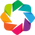

Gurobi version: (12, 0, 0)


In [71]:
import numpy as np
import pandas as pd
import gurobipy as gb
from gurobipy import Model, quicksum
import random as random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

from IPython.display import display, HTML
from heapq import heappush, heappop

# Set the default holoviews options
opts.Image(
	default_tools=['save', 'pan', 'wheel_zoom', 'box_zoom', 'reset'],
)
hv.plotting.bokeh.element.ElementPlot.active_tools = []  
# e.g. ['pan'] or `['box_zoom'], or `['wheel_zoom']` :)

# Set the default seaborn style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.5,
	},
)

print("Gurobi version:", gb.gurobi.version())

***


### Sets and Constants

##### Stations $N$, Arcs $\mathcal{A}$ and travel times $\omega^e_a$, $\omega^j_a$, $\Omega_{od}$

In [72]:
# Nodes (Stations) -------------------------------------------------------------
n = 10

# Set of stations																(N)
N = range(n)

# Stations coordinates (x, y):
# stations are randomly uniformly placed on inside a unitary circle
coords = []
coords_plot = []
for i in N:
	theta = random.uniform(0, 2 * np.pi)
	r = np.sqrt(random.uniform(0, 1))
	x = r * np.cos(theta)
	y = r * np.sin(theta)
	coords.append((x, y))
	coords_plot.append((x, y, i))

# Arcs -------------------------------------------------------------------------

# Set of arcs																	(A)
A = [(i, j) for i in N for j in N if i < j]

# Arc Pruning (optional)
# # Prune arcs set by randomly removing a percentage of them
# prune = 0.75
# retain = 1 - prune
# A = random.sample(A, int(retain * len(A)))

# # Check that all station have at least one connection otherwise add a random arc
# for i in N:
# 	if (not any(i == a for a, _ in A)) or (not any(i == a for _, a in A)):
# 		j = random.choice([j for j in N if i != j])
# 		A.append((i, j))

# Travel times -----------------------------------------------------------------

# Average travel timme by train on arc a										(omega^e)
# computed as the euclidean distance between the two stations
omega_e = {(i, j): np.sqrt((coords[i][0] - coords[j][0])**2 + (coords[i][1] - coords[j][1])**2) for i, j in A}

# Average travel time by alternative service on arc a							(omega^j)
# computed as increment of omega^e, in particular: omega^j = (1.35) * omega^e
omega_j = {a: 1.35 * omega_e[a] for a in A}

# Graph representation ---------------------------------------------------------
# graph weighted adjacency list for nodes and arcs
graph = {node: {} for node in N}
for node in N:
	for i, j in A:
		if i == node:
			graph[node][j] = omega_e[(i, j)]
		elif j == node:
			graph[node][i] = omega_e[(i, j)]

# Average travel time from any origin (o) to any destination (d)				(Omega)
# for any possible pair (o, d) of stations this is computed as the sum
# of the average travel times omega^e on the shortest path between o and d
# in the graph defined by the set of arcs A

# MOTE: eventually one can also make this quantity dependent on the time of the day
# and the day of the week, in order to account for the different traffic conditions

# Dijkstra's algorithm
def dijkstra(graph, source):
	# Initialize distances
	dist = {node: float("inf") for node in graph}
	dist[source] = 0
	# Initialize predecessors
	prev = {node: None for node in graph}
	# Initialize queue
	Q = deque(graph)
	while Q:
		u = min(Q, key=lambda node: dist[node])
		Q.remove(u)
		for v in graph[u]:
			alt = dist[u] + graph[u][v]
			if alt < dist[v]:
				dist[v] = alt
				prev[v] = u
	return dist, prev

# Compute Omega
Omega = {(o, d): dijkstra(graph, o)[0][d] for o in N for d in N if o != d}

# Plotting ---------------------------------------------------------------------
stations = hv.Points(coords_plot, vdims=["x", "y", "station"]).opts(
	tools=["hover"], 
	color="blue", 
	size=10, 
	marker="circle",
	hover_tooltips=[("Station", "@station"), ("X", "@x"), ("Y", "@y")]
)

arcs = hv.Overlay(
	[hv.Curve([coords[i], coords[j]]).opts(
		color="gray",
		line_width=2,
		tools=["hover"],
		hover_tooltips=[("Arc", f"({i}, {j})"), ("omega_e", f"{omega_e[(i, j)]:.2f}"), ("omega_j", f"{omega_j[(i, j)]:.2f}")]
	) for i, j in A]
)

theta = np.linspace(0, 2 * np.pi, 100)
circle = hv.Curve(
	[(np.cos(t), np.sin(t)) for t in theta]
).opts(
	color="black",
	line_dash="dashed",
	line_width=1
)

# Create background area outside the unit circle
background = hv.Area(
	[(-1.1, -1.1), (-1.1, 1.1), (1.1, 1.1), (1.1, -1.1), (-1.1, -1.1)]
).opts(
	fill_color="lightgray",
	line_color="lightgray"
)
background_circle = hv.Area(
	[(np.cos(t), np.sin(t)) for t in theta]
).opts(
	fill_color="white",
	line_color="white"
)

# Combine plots and set range
plot = (background * background_circle * circle * arcs * stations).opts(
	width=600, height=600,
	xlim=(-1.1, 1.1), ylim=(-1.1, 1.1),
	title="Stations and arcs",
	# xaxis=None, yaxis=None,
	# xlabel=None, ylabel=None
)

plot

:Overlay
   .Area.I        :Area   [x]   (y)
   .Area.II       :Area   [x]   (y)
   .Curve.I       :Curve   [x]   (y)
   .Curve.II      :Curve   [x]   (y)
   .Curve.III     :Curve   [x]   (y)
   .Curve.IV      :Curve   [x]   (y)
   .Curve.V       :Curve   [x]   (y)
   .Curve.VI      :Curve   [x]   (y)
   .Curve.VII     :Curve   [x]   (y)
   .Curve.VIII    :Curve   [x]   (y)
   .Curve.IX      :Curve   [x]   (y)
   .Curve.X       :Curve   [x]   (y)
   .Curve.XI      :Curve   [x]   (y)
   .Curve.XII     :Curve   [x]   (y)
   .Curve.XIII    :Curve   [x]   (y)
   .Curve.XIV     :Curve   [x]   (y)
   .Curve.XV      :Curve   [x]   (y)
   .Curve.XVI     :Curve   [x]   (y)
   .Curve.XVII    :Curve   [x]   (y)
   .Curve.XVIII   :Curve   [x]   (y)
   .Curve.XIX     :Curve   [x]   (y)
   .Curve.XX      :Curve   [x]   (y)
   .Curve.XXI     :Curve   [x]   (y)
   .Curve.XXII    :Curve   [x]   (y)
   .Curve.XXIII   :Curve   [x]   (y)
   .Curve.XXIV    :Curve   [x]   (y)
   .Curve.XXV     :Curve   [x]   (y)
   .Curve.XXVI    :Curve   [x]   (y)
   .Curve.XXVII   :Curve   [x]   (y)
   .Curve.XXVIII  :Curve   [x]   (y)
   .Curve.XXIX    :Curve   [x]   (y)
   .Curve.XXX     :Curve   [x]   (y)
   .Curve.XXXI    :Curve   [x]   (y)
   .Curve.XXXII   :Curve   [x]   (y)
   .Curve.XXXIII  :Curve   [x]   (y)
   .Curve.XXXIV   :Curve   [x]   (y)
   .Curve.XXXV    :Curve   [x]   (y)
   .Curve.XXXVI   :Curve   [x]   (y)
   .Curve.XXXVII  :Curve   [x]   (y)
   .Curve.XXXVIII :Curve   [x]   (y)
   .Curve.XXXIX   :Curve   [x]   (y)
   .Curve.XL      :Curve   [x]   (y)
   .Curve.XLI     :Curve   [x]   (y)
   .Curve.XLII    :Curve   [x]   (y)
   .Curve.XLIII   :Curve   [x]   (y)
   .Curve.XLIV    :Curve   [x]   (y)
   .Curve.XLV     :Curve   [x]   (y)
   .Curve.XLVI    :Curve   [x]   (y)
   .Points.I      :Points   [x,y]   (x,y,station)

##### Time Horizon $T$

In [73]:
# Discrete Time Periods
periods = 30

# Set of discrete time periods													(T)
T = range(periods)

##### Jobs $J$ and related parameters

In [74]:
# Jobs -------------------------------------------------------------------------
# Number of jobs
jobs = 6

# Set of jobs																	(J)
J = range(jobs)

# Processing time in days for job j												(pi)
# this is chosed randomly between 1 and len(T) (exclusive) time periods
# NOTE: an alternative could be making it a function of the length of the path
# of the job decided below (e.g. p_j = len(Aj[j]))
pi = {j: random.randint(1, len(T)//jobs) for j in J}

# Arcs subject to jobs ---------------------------------------------------------

# Set of direct train connections for a maintainance job j:						(A_j)
# each job will be scheduled on a random set of random length consisting
# in connected arcs in A
Aj = {}
for j in J:
	start_station = random.choice(N) # start station
	length = random.randint(1, n//3) # length of the path

	path = []
	current_station = start_station
	while len(path) < length:
		# Get all possible current station connections
		current_arcs = [a for a in A if current_station in a]
		# Filter out the arcs already in the path
		current_arcs = [a for a in current_arcs if a not in path]
		# If there are no more possible connections, break
		if not current_arcs: break
		# Choose a random arc
		next_arc = random.choice(current_arcs)
		# Add the arc to the path
		path.append(next_arc)
		# Update the current station
		current_station = next_arc[1] if next_arc[0] == current_station else next_arc[0]

	Aj[j] = path # add the path to the set of arcs for job j

# Set of maintenance jobs on arc a												(J_a)
# this set contains for each arc the IDs of the jobs that will be scheduled on it
Ja = {a: [j for j in J if a in Aj[j]] for a in A}

# Set of arcs that cannot be unavailable simultaneously							(C)
# for simplicity empty, but arcs can be inserted here with the attention
# that they are not in the same path of any job otherwise the model will be 
# automatically infeasible...
C = []

# Minimum time interval in days between maintanance of arc a					(tau)
# between one job and the schedule on the next in the same arc there might
# be the need of a break time interval for workers to move...
# ...this can be tweaked eventually
tau = {a: 0 for a in A}
# tau = {a: np.random.randint(0, len(T)//4) for a in A}

# Visualizations ---------------------------------------------------------------

# Dataframe of jobs and their attributes
data1 = {
	"Job": list(J),
	"pi": [pi[j] for j in J],
	"Aj": [Aj[j] for j in J]
}
df1 = pd.DataFrame(data1)
pd.set_option('display.max_colwidth', None)
display(HTML(df1.to_html(index=False)))

# Dataframe of arcs and the jobs scheduled on them
A_scheduled = [a for a in A if Ja[a]]
data2 = {
	"Arc": [f"{a}" for a in A_scheduled],
	"Job IDs": [Ja[a] for a in A_scheduled]
}
df2 = pd.DataFrame(data2)
pd.set_option('display.max_colwidth', None)
display(HTML(df2.to_html(index=False)))

# Plotting ---------------------------------------------------------------------
stations = hv.Points(coords_plot, vdims=["x", "y", "station"]).opts(
	tools=["hover"], 
	color="blue", 
	size=10, 
	marker="circle",
	hover_tooltips=[("Station", "@station"), ("X", "@x"), ("Y", "@y")]
)

arcs = hv.Overlay(
	[hv.Curve([coords[i], coords[j]]).opts(
		color="gray",
		line_width=2,
		tools=["hover"],
		hover_tooltips=[("Arc", f"({i}, {j})"), ("Jobs", f"{Ja[(i, j)]}" if (i, j) in Ja else "None")]
	) for i, j in A]
)

# Plot arcs corresponging to jobs in different colors

# Find the coordinates of the arcs corresponding to job j
arcsj = []
for j in J:
	for a in Aj[j]:
		arcsj.append(coords[a[0]])
		arcsj.append(coords[a[1]])

# Plot the arcs with different discrete colors
colors = sns.color_palette("tab10", n_colors=jobs)
for j, color in zip(J, colors):
	arcsj = []
	for a in Aj[j]:
		arcsj.append(coords[a[0]])
		arcsj.append(coords[a[1]])
	arcsj = hv.Curve(arcsj, label=f"Job {j}").opts(
		color=color,
		line_width=2,
		show_legend=True
	)
	arcs = arcs * arcsj

theta = np.linspace(0, 2 * np.pi, 100)
circle = hv.Curve(
	[(np.cos(t), np.sin(t)) for t in theta]
).opts(
	color="black",
	line_dash="dashed",
	line_width=1
)

# Create background area outside the unit circle
background = hv.Area(
	[(-1.1, -1.1), (-1.1, 1.1), (1.1, 1.1), (1.1, -1.1), (-1.1, -1.1)]
).opts(
	fill_color="lightgray",
	line_color="lightgray"
)
background_circle = hv.Area(
	[(np.cos(t), np.sin(t)) for t in theta]
).opts(
	fill_color="white",
	line_color="white"
)

# Combine plots and set range
plot = (background * background_circle * circle * arcs * stations).opts(
	width=600, height=600,
	xlim=(-1.1, 1.1), ylim=(-1.1, 1.1),
	title="Arcs interested by jobs",
	legend_position="bottom_right",
	show_legend=True,
	# xaxis=None, yaxis=None,
	# xlabel=None, ylabel=None
)

plot

Job,pi,Aj
0,3,"[(2, 9), (6, 9)]"
1,3,"[(2, 4)]"
2,3,"[(3, 7), (3, 5)]"
3,1,"[(0, 8), (1, 8), (1, 9)]"
4,3,"[(0, 7), (0, 9)]"
5,2,"[(4, 7)]"


Arc,Job IDs
"(0, 7)",[4]
"(0, 8)",[3]
"(0, 9)",[4]
"(1, 8)",[3]
"(1, 9)",[3]
"(2, 4)",[1]
"(2, 9)",[0]
"(3, 5)",[2]
"(3, 7)",[2]
"(4, 7)",[5]


:Overlay
   .Area.I        :Area   [x]   (y)
   .Area.II       :Area   [x]   (y)
   .Curve.I       :Curve   [x]   (y)
   .Curve.II      :Curve   [x]   (y)
   .Curve.III     :Curve   [x]   (y)
   .Curve.IV      :Curve   [x]   (y)
   .Curve.V       :Curve   [x]   (y)
   .Curve.VI      :Curve   [x]   (y)
   .Curve.VII     :Curve   [x]   (y)
   .Curve.VIII    :Curve   [x]   (y)
   .Curve.IX      :Curve   [x]   (y)
   .Curve.X       :Curve   [x]   (y)
   .Curve.XI      :Curve   [x]   (y)
   .Curve.XII     :Curve   [x]   (y)
   .Curve.XIII    :Curve   [x]   (y)
   .Curve.XIV     :Curve   [x]   (y)
   .Curve.XV      :Curve   [x]   (y)
   .Curve.XVI     :Curve   [x]   (y)
   .Curve.XVII    :Curve   [x]   (y)
   .Curve.XVIII   :Curve   [x]   (y)
   .Curve.XIX     :Curve   [x]   (y)
   .Curve.XX      :Curve   [x]   (y)
   .Curve.XXI     :Curve   [x]   (y)
   .Curve.XXII    :Curve   [x]   (y)
   .Curve.XXIII   :Curve   [x]   (y)
   .Curve.XXIV    :Curve   [x]   (y)
   .Curve.XXV     :Curve   [x]   (y)
   .Curve.XXVI    :Curve   [x]   (y)
   .Curve.XXVII   :Curve   [x]   (y)
   .Curve.XXVIII  :Curve   [x]   (y)
   .Curve.XXIX    :Curve   [x]   (y)
   .Curve.XXX     :Curve   [x]   (y)
   .Curve.XXXI    :Curve   [x]   (y)
   .Curve.XXXII   :Curve   [x]   (y)
   .Curve.XXXIII  :Curve   [x]   (y)
   .Curve.XXXIV   :Curve   [x]   (y)
   .Curve.XXXV    :Curve   [x]   (y)
   .Curve.XXXVI   :Curve   [x]   (y)
   .Curve.XXXVII  :Curve   [x]   (y)
   .Curve.XXXVIII :Curve   [x]   (y)
   .Curve.XXXIX   :Curve   [x]   (y)
   .Curve.XL      :Curve   [x]   (y)
   .Curve.XLI     :Curve   [x]   (y)
   .Curve.XLII    :Curve   [x]   (y)
   .Curve.XLIII   :Curve   [x]   (y)
   .Curve.XLIV    :Curve   [x]   (y)
   .Curve.XLV     :Curve   [x]   (y)
   .Curve.XLVI    :Curve   [x]   (y)
   .Curve.Job_0   :Curve   [x]   (y)
   .Curve.Job_1   :Curve   [x]   (y)
   .Curve.Job_2   :Curve   [x]   (y)
   .Curve.Job_3   :Curve   [x]   (y)
   .Curve.Job_4   :Curve   [x]   (y)
   .Curve.Job_5   :Curve   [x]   (y)
   .Points.I      :Points   [x,y]   (x,y,station)

##### Passenger demand $\phi$ and capacities $\beta$, $\Lambda$, $M$

In [75]:
# Total number of passengers
passengers = 100

# Passeger demand for each possible (origin, destination) pair at time t		(phi)
phi = {(o, d, t): random.randint(0, passengers) for o in N for d in N for t in T if o != d}

# Share of daily passenger demand for pair (o,d) in peak moment in time t		(beta)
min_share = 0.5
max_share = 0.7
beta = {(o, d, t): random.uniform(min_share, max_share) for o in N for d in N for t in T if o != d}

# Limited capacity of alternative services for arc a in A at time t				(Lambd)
min_capacity = int(0.5 * passengers/n)
max_capacity = int(0.7 * passengers/n)
Lambd = {(a, t): random.randint(min_capacity, max_capacity) for a in A for t in T}

# (Unlimited) capacity of train connections 									(M)
# train connections have virtually unlimited capacity that is modelled as a 
# very large number w.r.t. the passenger demand
sum_phi = sum(phi[(o, d, t)] for o in N for d in N for t in T if o != d)
M = sum_phi+(100*passengers)

##### Events $E$ and alternative routes $R$, $K$

In [76]:
# Set of event tracks at each time t											(E)
# in some time istances there might be some particular events in which traffic
# is increased by the factor beta and we will ask the capacity of the 
# alternative services to be able to deal with it as a constraint
n_max_events = 0 # maximum number of events simultaneously
E = {}
for t in T:
	E_tmp = []
	n_events = random.randint(0, n_max_events)

	# Randomly sample n_events connected tracks for the event
	for _ in range(n_events):
		start_station = random.choice(N) # start station
		length = random.randint(1, (n-1)//3) # length of the path

		path = []
		current_station = start_station
		while len(path) < length:
			# Get all possible current station connections
			current_arcs = [a for a in A if current_station in a]
			# Filter out the arcs already in the path
			current_arcs = [a for a in current_arcs if a not in path]
			# If there are no more possible connections, break
			if not current_arcs: break
			# Choose a random arc
			next_arc = random.choice(current_arcs)
			# Add the arc to the path
			path.append(next_arc)
			# Update the current station
			current_station = next_arc[1] if next_arc[0] == current_station else next_arc[0]

		E_tmp.append(path) # add the path to the set of arcs for job j

	E[t] = E_tmp

# # Number of routes considered when travelling from any o to d					(K)
K = 3 

# # Set of routes from o to d													(R)
# each route is a list of arcs that compose the path from o to d
R = {}

# Return set of arcs of shortest path from start to end
def shortest_arcs(predecessors, start, end):
	path = []
	node = end
	while node != start:
		path.append((predecessors[node], node))
		node = predecessors[node]
	path.reverse()
	return path

# Return list of nodes of shortest path from start to end
def shortest_nodes(predecessors, start, end):
	path = []
	node = end
	while node is not None:
		path.append(node)
		node = predecessors[node]
	path.reverse()
	return path

# Convert a list of nodes to a suitable list of arcs in A
def nodes_to_arcs(nodes):
	path = []
	for i in range(len(nodes)-1):
		if nodes[i] < nodes[i+1]:
			path.append((nodes[i], nodes[i+1]))
		else:
			path.append((nodes[i+1], nodes[i]))
	return path

# Convert a list of arcs to a suitable list of nodes in N
# NOTE: arcs are always in the form (i, j) with i < j, hence
# the conversion is not immediate becase we need to check the correct order
# E.g. arcs_to_nodes([(0, 1), (1, 2), (2, 3)]) = [0, 1, 2, 3] (easy)
# but arcs_to_nodes([(5, 9), (3, 5), (3, 8)]) = [9, 5, 3, 8] (not immediate)
def arcs_to_nodes(arcs):
	nodes = []
	if not arcs: return nodes

	# If it's just one arc, return the list of it
	if len(arcs) == 1: return list(arcs[0])

	# Start with the first arc in the correct order
	if arcs[0][1] == arcs[1][0] or arcs[0][1] == arcs[1][1]:
		nodes.append(arcs[0][0])
		nodes.append(arcs[0][1])
	elif arcs[0][0] == arcs[1][0] or arcs[0][0] == arcs[1][1]:
		nodes.append(arcs[0][1])
		nodes.append(arcs[0][0])
	else:
		raise ValueError("Arcs in input list are not connected")

	# Add the remaining arcs
	for i, j in arcs[1:]:
		if nodes[-1] == i:
			nodes.append(j)
		else:
			nodes.append(i)

	return nodes

# Yen's K-shortest paths algorithm
def YenKSP(graph, source, sink, K):
	
	# Initialise lists
	A = [] # list of k-shortest paths
	B = [] # list of potential k-th shortest paths

	# Determine the shortest path from the source to the sink
	dist, prev = dijkstra(graph, source)
	if prev[sink] == None: return A # no shortest path found
	A.append((dist[sink], shortest_nodes(prev, source, sink)))

	for k in range(1,K):
		for i in range(len(A[-1][1]) - 1):
			spur_node = A[-1][1][i] # the i-th node in the previously found k-shortest path
			root_path = A[-1][1][:i+1] # nodes from source to spur_node

			# Remove arcs that are part of the previous shortest paths and
			# which share the same root path
			removed_arcs = []
			for path in A:
				if len(path[1]) > i and path[1][:i+1] == root_path:
					u, v = path[1][i], path[1][i + 1]
					if v in graph[u]:
						removed_arcs.append((u, v, graph[u][v]))
						del graph[u][v]
					
			# Calculate the new spur path from the spur node to the sink
			dist, prev = dijkstra(graph, spur_node)
			if prev[sink] is not None:
				spur_path = shortest_nodes(prev, spur_node, sink)
				total_path = root_path[:-1] + spur_path

				# Check for repeated nodes in the total path
				# (we shall not have repeated nodes in a path)
				if len(set(total_path)) == len(total_path):
					total_cost = sum(graph[total_path[i]][total_path[i + 1]] for i in range(len(total_path) - 1))
					B.append((total_cost, total_path))

			# Add back the removed arcs
			for u, v, cost in removed_arcs:	graph[u][v] = cost
		
		# Handle no spur path found case
		if not B: break

		# Sort potential paths by cost and 
		# add the lowest cost path to the k shortest paths
		B.sort()
		A.append(B.pop(0)) # pop to remove it from B

	# Clean A and convert its elements in lists of arcs
	A = [nodes_to_arcs(path) for _, path in A]

	return A

# Generate routes for each pair (o, d)
for o in N:
	for d in N:
		if o != d:
			R[(o, d)] = YenKSP(graph, o, d, K)

display(R)

{(0, 1): [[(0, 1)], [(0, 2), (1, 2)], [(0, 5), (1, 5)]],
 (0, 2): [[(0, 2)], [(0, 1), (1, 2)], [(0, 4), (2, 4)]],
 (0, 3): [[(0, 3)], [(0, 2), (2, 3)], [(0, 1), (1, 3)]],
 (0, 4): [[(0, 4)], [(0, 5), (4, 5)], [(0, 8), (4, 8)]],
 (0, 5): [[(0, 5)], [(0, 8), (5, 8)], [(0, 6), (5, 6)]],
 (0, 6): [[(0, 6)], [(0, 8), (6, 8)], [(0, 5), (5, 6)]],
 (0, 7): [[(0, 7)], [(0, 4), (4, 7)], [(0, 5), (5, 7)]],
 (0, 8): [[(0, 8)], [(0, 5), (5, 8)], [(0, 6), (6, 8)]],
 (0, 9): [[(0, 9)], [(0, 5), (5, 9)], [(0, 8), (8, 9)]],
 (1, 0): [[(0, 1)], [(1, 2), (0, 2)], [(1, 5), (0, 5)]],
 (1, 2): [[(1, 2)], [(1, 3), (2, 3)], [(1, 4), (2, 4)]],
 (1, 3): [[(1, 3)], [(1, 2), (2, 3)], [(1, 4), (3, 4)]],
 (1, 4): [[(1, 4)], [(1, 2), (2, 4)], [(1, 7), (4, 7)]],
 (1, 5): [[(1, 5)], [(1, 2), (2, 5)], [(1, 8), (5, 8)]],
 (1, 6): [[(1, 6)], [(1, 8), (6, 8)], [(1, 5), (5, 6)]],
 (1, 7): [[(1, 7)], [(1, 2), (2, 7)], [(1, 4), (4, 7)]],
 (1, 8): [[(1, 8)], [(1, 5), (5, 8)], [(0, 1), (0, 8)]],
 (1, 9): [[(1, 9)], [(1, 5), (5

***

### Model

In [77]:
# Model
model = Model()
model.ModelSense = gb.GRB.MINIMIZE

***

### Decision Variables

In [78]:
# Start time of j^th job														(y)
y = model.addVars(J, T, vtype=gb.GRB.BINARY, name='y') 							# y[j,t] = 1 if job j starts at time t, 0 otherwise

# Availability of arc a at time t												(x)
x = model.addVars(A, T, vtype=gb.GRB.BINARY, name='x')							# x[a,t] = 1 if arc a is available at time t, 0 otherwise

# Route option k used when travelling from o to d at time t						(h)
h = model.addVars(N, N, T, range(K), vtype=gb.GRB.BINARY, name='h')				# h[o,d,t,k] = 1 if route option k is used when travelling from o to d at time t, 0 otherwise

# Travel time traversing arc a at time t										(w)
w = model.addVars(A, T, lb=0, vtype=gb.GRB.CONTINUOUS, name='w')				# w[a,t] = travel time (continuous)

# Travel time from origin to destination at time t								(v)
v = model.addVars(N, N, T, lb=0, vtype=gb.GRB.CONTINUOUS, name='v')				# v[o,d,t] = travel time (continuous)

***

### Objective Function

In [79]:
# Minimize total passenger delays												(1)
model.setObjective(
	quicksum(
		quicksum(
			phi[o, d, t] * (v[o, d, t] - Omega[o, d]) for t in T
		) for o in N for d in N if o != d
	)
)

***

### Constraints

Maintainance scheduling constraints

In [80]:
# Job started and completed within time horizon									(2)
for j in J:
	model.addConstr(
		quicksum(y[j, t] for t in range(len(T) - pi[j] + 1)) == 1
	)

# Availability of arc a at time t												(3)
for a in A:
	for t in T:
		for j in Ja[a]:
			model.addConstr(
				x[*a, t] + quicksum(y[j, tp] for tp in range(max(0, t-pi[j]+1), t)) <= 1
			)

# Increased travel time for service replacement									(4)
for a in A:
	for t in T:
		model.addConstr(
			w[*a, t] == x[*a, t] * omega_e[a] + (1 - x[*a, t]) * omega_j[a]
		)

# Ensure correct arc travel times for free variables							(5)
for a in A:
	model.addConstr(
		quicksum(x[*a,t] for t in T) == len(T) - quicksum(pi[j] for j in Ja[a])
	)

Restrictions on maintenance scheduling

In [81]:
# Arcs that cannt be unavailable simultaneously									(6)
for t in T:
	for j in J:
		for c in C:
			model.addConstr(
				quicksum(1 - x[*a, t] for a in c) <= 1
			)

# Non overlapping jobs on same arc												(7)
for a in A:
	for t in T:
		model.addConstr(
			quicksum(
				quicksum(
					y[j, tp] for tp in range(max(0, t-pi[j]-tau[a]), len(T))
				) for j in Ja[a]
			) <= 1
		)

Event Requests

In [82]:
# Each track segment in an event request has limited capacity					(8)
for t in T:
	for i_s, s in enumerate(E[t]):
		model.addConstr(
			quicksum(
			quicksum(
				quicksum(
					h[o, d, t, i]*beta[o, d, t]*phi[o, d, t] for i in range(K) if a in R[(o, d)][i]
				) for o in N for d in N if o != d
				) for a in s
			) <= quicksum(Lambd[a, t] for a in s) + (M * quicksum(x[*a, t] for a in s))
			# ) <= Lambd[s, t] + (M * quicksum(x[*a, t] for a in s))
		)

Passenger Route Choice and Evaluation

In [83]:
# Passeger flow from o to d is served by one of predefined routes				(9)
for t in T:
	for o in N:
		for d in N:
			if o != d:
				model.addConstr(
					quicksum(
						h[o, d, t, i] for i in range(K)
					) == 1
				)

# Lower bound for travel time from o to d										(10)
for t in T:
	for o in N:
		for d in N:
			if o != d:
				for i in range(K):
					model.addConstr(
						v[o, d, t] >= quicksum(w[*a, t] for a in R[(o, d)][i]) - M*(1 - h[o, d, t, i])
					)

# Upper bound for travel time from o to d										(11)
for t in T:
	for o in N:
		for d in N:
			if o != d:
				for i in range(K):
					model.addConstr(
						v[o, d, t] <= quicksum(w[*a, t] for a in R[(o, d)][i])
					)

***

### Optimisation

In [84]:
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Arch Linux")

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21981 rows, 14880 columns and 70226 nonzeros
Model fingerprint: 0x0d76cec3
Variable types: 4350 continuous, 10530 integer (10530 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+05]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+05]
Presolve removed 21773 rows and 14675 columns
Presolve time: 0.08s
Presolved: 208 rows, 205 columns, 665 nonzeros
Variable types: 58 continuous, 147 integer (147 binary)
Found heuristic solution: objective 113.0584985

Root relaxation: objective 1.121464e+02, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

***